In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
def prepare_data(csv_file, random_state):
    """Prepare data.
    
    Separate target and feature columns.
    Make one-hot-encoding for day_name column.
    Make Scaling on feature columns.
    Train/Test Split.
            
        Parameters:
        -----------
        csv_file (str): File path to dataset.
        random_state: For different train test splits

        Returns:
        --------
        X_train, X_test, y_train, y_test: Train/Test data
    
    """
    df = pd.read_csv(csv_file)
    y = df.pop("demand") 

    # Do OneHotEncoding for the column day_name or use sine cosine transformation
    df = pd.get_dummies(df, columns=['day_name'])
    
    # Make train test split
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=random_state)
    
    # create scaler
    scaler = StandardScaler()
    
    # fit on train data
    scaler.fit(X_train)
    
    # Transfrom train and test 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # log transformation for y_train
    return X_train, X_test, y_train, y_test

In [3]:
def hyperparameter_optimization(X, y, model, param_grid):
    """Make hyperparameter optimization.
    
        Parameters:
        -----------
        X: Features of train data
        y: Target Column of train data
        model (SklearnModel): Model on which hyper. opt will be made.
        param_grid (dict): Parameter grid for GridSearch.
        
        Returns:
        --------
        SklearnModel: Best model found with GridSearch.
    
    """
    best_params = {}
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

In [4]:
def create_learning_curves(estimators, X_train, y_train):
    """Create learning curve for all best models.
    
        Parameters:
        -----------
        estimators (list): List of models found through hyperparameter opt.
        X_train: Features of train data
        y_train: Target Column of train data
    
    """
    for model in estimators: 
        model_name = model.__class__.__name__
        
        # Create plain untrained model instance
        params = model.get_params()
        # Create a new instance of the Model class with the same parameters
        untrained_model = model.__class__(**params)

        # Use cross validation cv = 10
        train_sizes, train_scores, test_scores = learning_curve(estimator=untrained_model, X=X_train, y=y_train,
                                                                cv=5, train_sizes=np.linspace(0.1, 1.0, 10), 
                                                                n_jobs=-1)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
        plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
        plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
        plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
        plt.title(f'Learning Curve for {model_name}')
        plt.xlabel('Training Data Size')
        plt.grid()
        plt.ylabel('Model accuracy')
        plt.legend(loc='lower right')
        plt.savefig(f'figures/learning_curve_{model_name}.png')
        plt.show()


In [5]:
def train_models(estimators, X_train, y_train):
    """Train models on train data.
    
        For every model type a hyperparameter optimization is done.
        For every best model of a model type, a learning curve is generated.
        The best estimators of each model type will be returned.
    
        Parameters:
        -----------
        estimators (list): List of tuples. Sklearn Model and param_grid dict.
        X_train: Features of train data
        y_train: Target Column of train data
        
        Returns:
        --------
        list: Best estimators (with best parameters) of each model type
    """
    best_estimators = []
    for (model, param_grid) in estimators:
        print(f"Start hyperparameter opt for: {model.__class__.__name__}")
        opt_model = hyperparameter_optimization(X_train, y_train, model, param_grid=param_grid)
        print(f"End hyperparameter opt for: {model.__class__.__name__}")

        best_estimators.append(opt_model)
    
    create_learning_curves(best_estimators, X_train, y_train)
    return best_estimators

In [6]:
def calculate_mean_values(dict_list):
    mean_values = {}
    for key in dict_list[0].keys():
        values = [d[key] for d in dict_list]
        mean_values[key] = sum(values) / len(values)
    return mean_values


def scatter_regression_plot(y_true, y_pred):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.tight_layout()
    plt.scatter(y_true, y_pred, color="darkblue")
    plt.xlabel('True Values', fontsize=14)
    plt.ylabel('Predictions',fontsize=14)
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([100, 2000], [100, 2000], color="black")
    plt.savefig(f'figures/scatter_regression_plot.png')
    plt.show()
    

def main(estimators, iterations=3):
    """Compute different training loops.
    
        Parameters:
        -----------
        estimators (list): List of tuples of sklearn models and parameters for hyperparameter optimization
        iterations (int): How many trainings iterations with different train/test split. 
    
    """
    iteration_best_estimators = []
    for state in range(iterations):
        print(f"Start Iteration with new Train/Test Split: {state}")
        # Train Model for all_demand
        X_train, X_test, y_train, y_test = prepare_data("data/all_demand.csv", random_state=state)

        # Train different model classes. Make Hyperparametrization for every model class just on train data.
        # Then take the best model of each class and plot a learning curve
        best_estimators = train_models(estimators, X_train, y_train)
          
        # Test/Evaluate all best_estimators on test data and generate score
        print(best_estimators)
        estimator_scores = {}
        for model in best_estimators:
            # predict r2 score
            score = model.score(X_test, y_test)
            estimator_scores[model.__class__.__name__] = score

        print("All best models with score: \n" + str(estimator_scores) + "\n")
        # Add models with score to final list
        iteration_best_estimators.append(estimator_scores)
        
        # Take best model of this iteration (with highest score)
        model_name = max(estimator_scores, key=lambda k: estimator_scores[k])
        print(f"The best model is: {model_name}")
        best_model = [model for model in best_estimators if model_name==model.__class__.__name__][0]
        print(best_model)
        
        # Predict with best model of this iteration on test data 
        predictions = best_model.predict(X_test)
        
        # Make scatter regression plot
        scatter_regression_plot(y_test, predictions)
        
    # After finishing all iterations calculate mean score for each model class
    results_estimators = calculate_mean_values(iteration_best_estimators)
    print(results_estimators)
    
    # Convert all results_estimators to dataframe with scores
    df_result = pd.DataFrame(list(results_estimators.items()), columns=['Model', 'R2-Score'])

    # Generate latex code
    print(df_result.to_latex())

Start Iteration with new Train/Test Split: 0
Start hyperparameter opt for: DecisionTreeRegressor
End hyperparameter opt for: DecisionTreeRegressor
Start hyperparameter opt for: GradientBoostingRegressor
End hyperparameter opt for: GradientBoostingRegressor
Start hyperparameter opt for: SVR
End hyperparameter opt for: SVR
Start hyperparameter opt for: MLPRegressor


C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [            nan  7.74224995e-01             nan  8.32847581e-01
             nan  7.62057556e-01             nan  8.57781147e-01
 -9.35146925e+76  7.55502020e-01             nan  8.28064776e-01
  3.48711854e-02 -4.52217211e-01  1.09815539e-01 -7.08076905e-02
  3.96394381e-02 -4.58027101e-01  2.15432742e-01 -7.75928634e-02
  3.17364185e-02 -4.56852991e-01  1.37876350e-01 -7.38005725e-02]
  warnings.warn(
C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [            nan  7.94303418e-01             nan  8.63154673e-01
             nan  7.88997517e-01             nan  8.86718289e-01
 -9.80334784e+76  7.79743068e-01             nan  8.52079748e-01
  3.53542925e-02 -4.51195226e-01  1.17526721e-01 -7.04877045e-02
  4.53051306e-02 -4.57079787e-01  2.19384000e

End hyperparameter opt for: MLPRegressor


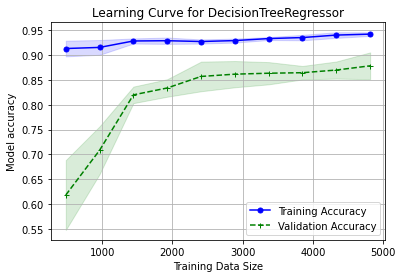

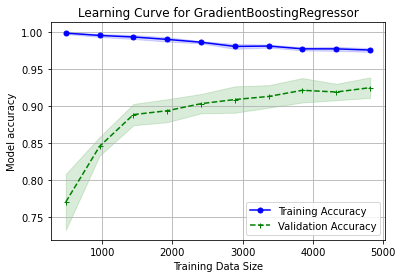

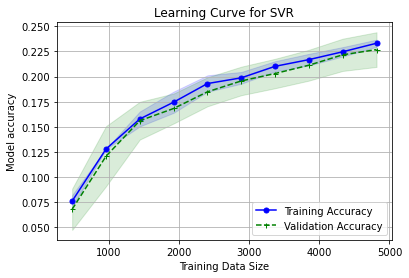

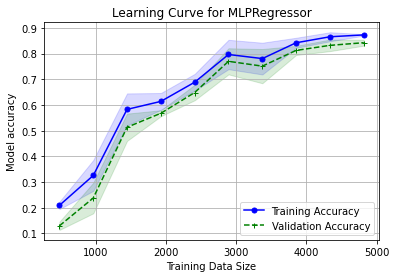

[DecisionTreeRegressor(criterion='friedman_mse', max_depth=15,
                      min_samples_leaf=4, min_samples_split=10), GradientBoostingRegressor(criterion='squared_error', learning_rate=0.2,
                          loss='huber', max_depth=8), SVR(C=10, epsilon=1), MLPRegressor(alpha=0.05, batch_size=500, hidden_layer_sizes=(25, 100, 25),
             max_iter=500)]
All best models with score: 
{'DecisionTreeRegressor': 0.8762161809737373, 'GradientBoostingRegressor': 0.9234975416352051, 'SVR': 0.24639013261176002, 'MLPRegressor': 0.8445209272182395}

The best model is: GradientBoostingRegressor
GradientBoostingRegressor(criterion='squared_error', learning_rate=0.2,
                          loss='huber', max_depth=8)


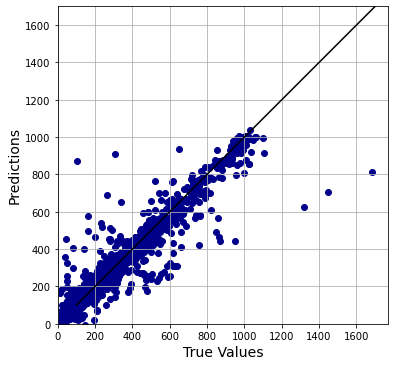

Start Iteration with new Train/Test Split: 1
Start hyperparameter opt for: DecisionTreeRegressor
End hyperparameter opt for: DecisionTreeRegressor
Start hyperparameter opt for: GradientBoostingRegressor
End hyperparameter opt for: GradientBoostingRegressor
Start hyperparameter opt for: SVR
End hyperparameter opt for: SVR
Start hyperparameter opt for: MLPRegressor


C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan  0.76041819         nan  0.83567793         nan  0.6790522
         nan  0.84965642         nan  0.82476367         nan  0.8608985
  0.12383474 -0.46726173  0.19983359 -0.08273925  0.08517991 -0.46550804
  0.20486621 -0.07560163  0.11933765 -0.46932765  0.13192377 -0.08009851]
  warnings.warn(
C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [        nan  0.78893842         nan  0.86052898         nan  0.69867796
         nan  0.88183196         nan  0.84815654         nan  0.88928932
  0.11986766 -0.4666623   0.21047625 -0.08231023  0.0788504  -0.46496782
  0.21654291 -0.07495844  0.12236585 -0.46884493  0.15044844 -0.07941132]
  warnings.warn(
C:\Users\patri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692

End hyperparameter opt for: MLPRegressor


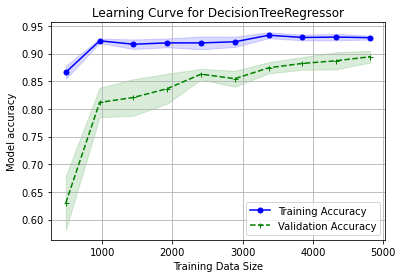

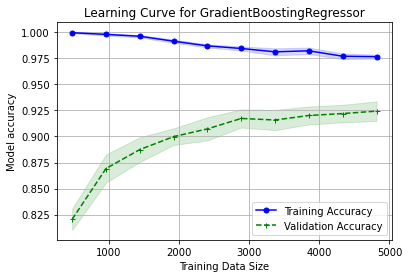

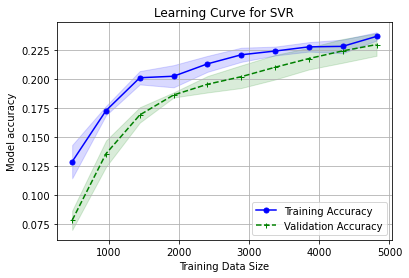

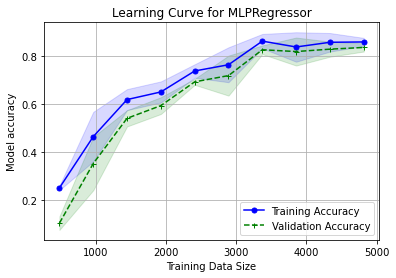

[DecisionTreeRegressor(criterion='absolute_error', max_depth=20,
                      min_samples_leaf=4, min_samples_split=5), GradientBoostingRegressor(criterion='squared_error', loss='huber', max_depth=8,
                          n_estimators=200), SVR(C=10, epsilon=1), MLPRegressor(alpha=0.1, batch_size=500, hidden_layer_sizes=(25, 100, 25),
             max_iter=500)]
All best models with score: 
{'DecisionTreeRegressor': 0.8944201864673733, 'GradientBoostingRegressor': 0.927847783222097, 'SVR': 0.24710702809767537, 'MLPRegressor': 0.8492519567661317}

The best model is: GradientBoostingRegressor
GradientBoostingRegressor(criterion='squared_error', loss='huber', max_depth=8,
                          n_estimators=200)


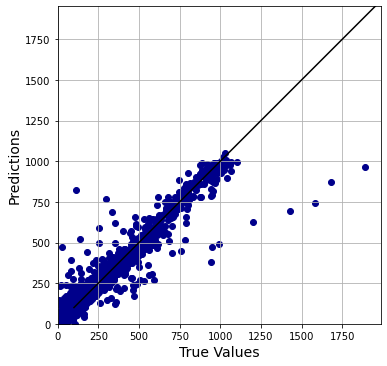

Start Iteration with new Train/Test Split: 2
Start hyperparameter opt for: DecisionTreeRegressor
End hyperparameter opt for: DecisionTreeRegressor
Start hyperparameter opt for: GradientBoostingRegressor
End hyperparameter opt for: GradientBoostingRegressor
Start hyperparameter opt for: SVR
End hyperparameter opt for: SVR
Start hyperparameter opt for: MLPRegressor


C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan  0.7653478          nan  0.84809775         nan  0.76300883
         nan  0.79591096         nan  0.79418364         nan  0.85195215
  0.13504674 -0.4519884   0.29648368 -0.06781506  0.10499076 -0.45298468
  0.12729853 -0.06977991  0.11559491 -0.45400272  0.18609123 -0.0645471 ]
  warnings.warn(
C:\Users\patri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [        nan  0.7909895          nan  0.87420557         nan  0.78470203
         nan  0.8219079          nan  0.82253863         nan  0.87739953
  0.14992628 -0.45171092  0.32579959 -0.06704441  0.11404378 -0.4528094
  0.14680081 -0.06936018  0.1161901  -0.45360088  0.20985014 -0.06353492]
  warnings.warn(


End hyperparameter opt for: MLPRegressor


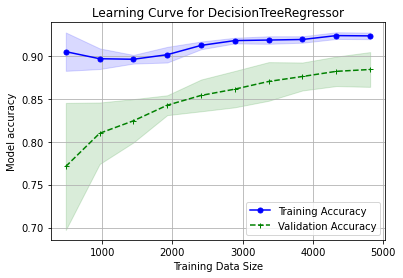

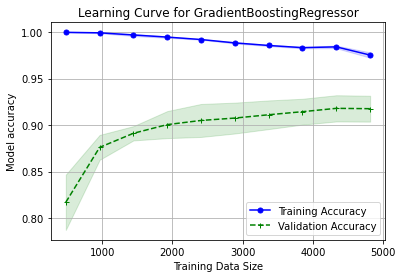

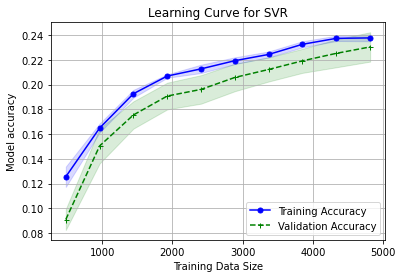

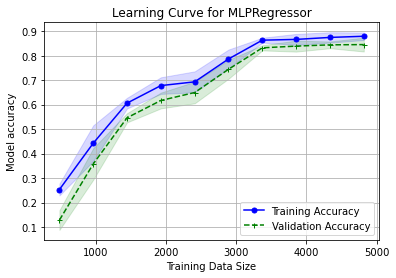

[DecisionTreeRegressor(criterion='absolute_error', max_depth=15,
                      min_samples_leaf=4, min_samples_split=10), GradientBoostingRegressor(loss='huber', max_depth=8, n_estimators=200), SVR(C=10, epsilon=1), MLPRegressor(alpha=0.1, batch_size=500, hidden_layer_sizes=(25, 100, 25),
             max_iter=500)]
All best models with score: 
{'DecisionTreeRegressor': 0.879633817053381, 'GradientBoostingRegressor': 0.928454665196763, 'SVR': 0.22546003367226963, 'MLPRegressor': 0.8558387365409494}

The best model is: GradientBoostingRegressor
GradientBoostingRegressor(loss='huber', max_depth=8, n_estimators=200)


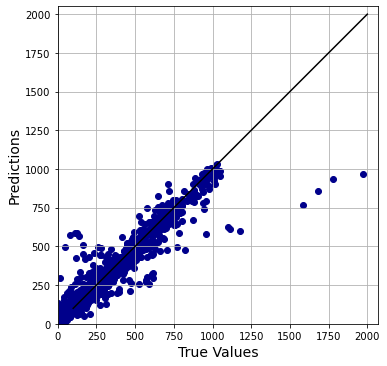

{'DecisionTreeRegressor': 0.8834233948314972, 'GradientBoostingRegressor': 0.9265999966846884, 'SVR': 0.23965239812723502, 'MLPRegressor': 0.8498705401751069}
\begin{tabular}{llr}
\toprule
{} &                      Model &  R2-Score \\
\midrule
0 &      DecisionTreeRegressor &  0.883423 \\
1 &  GradientBoostingRegressor &  0.926600 \\
2 &                        SVR &  0.239652 \\
3 &               MLPRegressor &  0.849871 \\
\bottomrule
\end{tabular}



C:\Users\patri\AppData\Local\Temp\ipykernel_4664\1179775215.py:76: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_result.to_latex())


In [7]:
if __name__ == '__main__':
    # Define list of tuples of sklearn models and parameters for hyperparameter optimization
    estimators = [
                  # DecisionTree
                  (DecisionTreeRegressor(), 
                   {
                        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
                        'max_depth': [5, 10, 15, 20, None], 
                        'min_samples_split': [2, 5, 10], 
                        'min_samples_leaf': [1, 2, 4]
                    } 
                  ),

                  # GradientBoosting
                  (GradientBoostingRegressor(), 
                   {
                        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                        'criterion': ['friedman_mse', 'squared_error'],
                        'learning_rate': [0.1, 0.2],
                        'n_estimators': [100, 200],
                        'max_depth': [3, 8],
                        'max_features': ['auto', 'sqrt', 'log2', None]
                    }
                  ),

                  # Support Vector Machine
                  (SVR(),
                   {
                        'C': [0.1, 0.5, 1, 10],
                        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                        'epsilon': [0.01, 0.05, 0.1, 1]
                   }
                  ),

                  # MlPRegressor
                  (MLPRegressor(),
                   {
                        'hidden_layer_sizes': [(50,25, 10), (25,100,25)],
                        'activation': ['relu', 'tanh'],
                        'solver': ['sgd', 'adam'],
                        'alpha': [0.0001, 0.05, 0.1],
                        'batch_size': [500],
                        'max_iter': [500]
                   }

                  )
                ]
    
    
    # Execute main function
    main(estimators, iterations=3)